# Analiza rekomendacji filmów
Dawid Stasiak 148112

In [149]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

In [150]:
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")

In [151]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [152]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [153]:
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)").astype("Int64")
movies_df["title"] = movies_df["title"].str.replace(r" \(\d{4}\)", "", regex=True)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [154]:
g = nx.Graph()

for _, movie in movies_df.iterrows():
    g.add_node(movie["title"], 
               type="movie",
               year=movie["year"])

user_ids = ratings_df["userId"].unique()
for user_id in user_ids:
    g.add_node(f"user_{user_id}", type="user")

movies_ratings_df = pd.merge(ratings_df, movies_df, on="movieId")
for _, rating in movies_ratings_df.iterrows():
    g.add_edge(f"user_{rating["userId"]}", 
               rating["title"], 
               rating=rating["rating"])
    
isolated_nodes = list(nx.isolates(g))
g.remove_nodes_from(isolated_nodes)

In [155]:
degree_centrality = nx.degree_centrality(g)

movie_centrality = {node: centrality for node, centrality in degree_centrality.items() if g.nodes[node]["type"] == "movie"}

top_movies = sorted(movie_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

for movie, centrality in top_movies:
    print(f"{movie}: {centrality}")

Forrest Gump: 0.03272003978120338
Shawshank Redemption, The: 0.03152660367976131
Pulp Fiction: 0.030532073595226254
Silence of the Lambs, The: 0.027747389358528093
Matrix, The: 0.02764793635007459


In [156]:
g_low = g.edge_subgraph([(u, v) for u, v, data in g.edges(data=True) if data.get("rating") < 3])

low_degree_centrality = nx.degree_centrality(g_low)

low_movie_centrality = {node: centrality for node, centrality in low_degree_centrality.items() if g.nodes[node]["type"] == "movie"}

top_low_movies = sorted(low_movie_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

for movie, centrality in top_low_movies:
    print(f"{movie}: {centrality}")

Ace Ventura: Pet Detective: 0.008221476510067114
Dumb & Dumber (Dumb and Dumber): 0.007550335570469798
Star Wars: Episode I - The Phantom Menace: 0.00721476510067114
Ace Ventura: When Nature Calls: 0.007046979865771812
Batman Forever: 0.006879194630872483


In [157]:
sampled_movies = np.random.choice(list(g.nodes()), int(g.number_of_nodes() * 0.25))
g_sampled = g.subgraph(sampled_movies).copy()

isolated_nodes = list(nx.isolates(g_sampled))
g_sampled.remove_nodes_from(isolated_nodes)

In [158]:
movies = [n for n, d in g_sampled.nodes(data=True) if d.get("type") == "movie"]

g_movies = nx.bipartite.weighted_projected_graph(g_sampled, movies)

In [159]:
movies_betweenness = nx.betweenness_centrality(g_movies, weight="weight", k=200)

top_5_betweenness = sorted(movies_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

for movie, centrality in top_5_betweenness:
    print(f"{movie}: {centrality}")

Princess Bride, The: 0.009512603931438678
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark): 0.008477134534237284
Godfather, The: 0.007719658064500206
Fargo: 0.007478021453987345
Unbreakable: 0.007261539068862757


In [160]:
communities = nx.community.greedy_modularity_communities(g_movies)
print(f"Number of communities: {len(communities)}")

Number of communities: 3


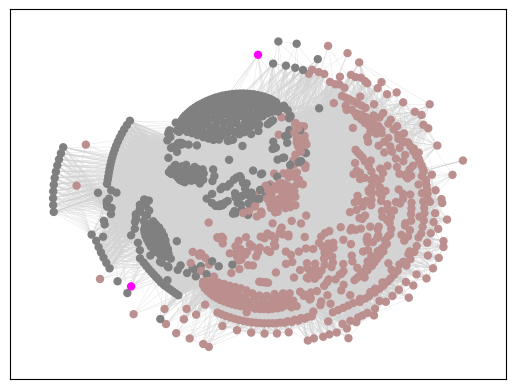

In [161]:
def find_community(node_id, communities):
    for community_id, community_members in enumerate(communities):
        if node_id in community_members:
            return community_id
    return -1

all_colors = list(mcolors.CSS4_COLORS.keys())
_colors = np.random.choice(all_colors, size=len(communities), replace=False)
node_colors = ["lightgray"] * g_movies.number_of_nodes()

for n in range(g_movies.number_of_nodes()):
    node_id = list(g_movies.nodes())[n]
    n_community = find_community(node_id, communities)
    if n_community >= 0:
        node_colors[n] = _colors[n_community]

nx.draw_networkx(
    g_movies,
    pos=nx.kamada_kawai_layout(g_movies),
    node_size=25,
    width=0.2,
    edge_color="lightgray",
    node_color=node_colors,
    with_labels=False
)